In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

/Users/hwk06023/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
import numpy as np
from glob import glob
import os
from PIL import Image
import cv2
from tqdm import tqdm

images = glob("./train/images/*.jpg")

masked_imgs = list()
sliced_images = list()

# 데이터 변수에 저장. 이미지랑 yolo형 segmentation 데이터에서 마스크 생성하고 저장한거임

for image in tqdm(images, total=len(images)):
  fname = os.path.basename(image)
  label = "./train/labels/"+fname[:-4]+".txt"
  image = np.array(Image.open(image))
  sliced_images.append(image)
  width, height, _ = image.shape

  mask = np.zeros((width, height), dtype=np.uint8)

  segmentations = list()
  bboxes = list()
  with open(label) as f:
    for line in f:
      coords = line.split(" ")
      x_coords = [int(float(coord) * width) for i, coord in enumerate(coords) if i % 2 != 0]
      y_coords = [int(float(coord) * height) for i, coord in enumerate(coords) if i % 2 == 0]
      del y_coords[0]

      segmentation = list(zip(x_coords, y_coords))
      segmentations.append(np.array(segmentation))
      bbox = [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]
      bboxes.append(bbox)

      #sliced_images.append(image[bbox[1]:bbox[3], bbox[0]:bbox[2], :])

  mask = cv2.fillPoly(mask, segmentations, 1)

  masked_img1 = mask * image[:, :, 0]
  masked_img2 = mask * image[:, :, 1]
  masked_img3 = mask * image[:, :, 2]
  masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))
  masked_imgs.append(masked_img)

 84%|████████▍ | 146/173 [00:00<00:00, 752.85it/s]


FileNotFoundError: [Errno 2] No such file or directory: './train/labels/KakaoTalk_20230802_011016785.txt'

In [9]:
# 데이터 증강한 것들

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation((-10, 10)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 얘는 걍 이미지에만 transform만 적용해준거
# mask는 학습시에 안써서 없는거임
class MyDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.transform is not None:
            image = self.transform(image)

        return image, 0

batch_size = 16

train_dataset = MyDataset(sliced_images[:int(len(sliced_images) * 1)], transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = MyDataset(masked_imgs[int(len(masked_imgs) * 0.8):], transform=test_transform)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size // 8, shuffle=False)

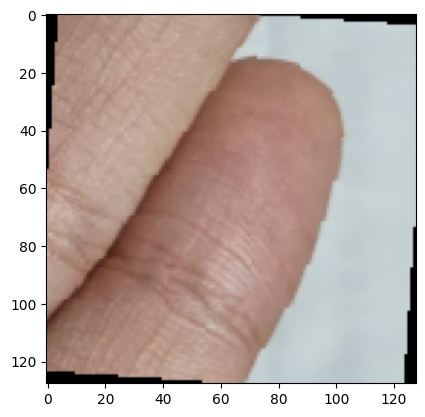

In [10]:
import matplotlib.pyplot as plt
plt.imshow(next(iter(train_dataloader))[0][0].permute(1,2,0))

In [13]:
segmentations = [
                [
                    285.18730937897067,
                    465.87426309669866
                ],
                [
                    251.09437974729423,
                    476.9915227592018
                ],
                [
                    225.1541072014537,
                    505.8963978817099
                ],
                [
                    228.9953040878808,
                    511.696347245232
                ],
                [
                    232.7248693010385,
                    570.6234776131232
                ],
                [
                    218.55252149103939,
                    628.8046949383829
                ],
                [
                    208.85565193682947,
                    699.6664339883786
                ],
                [
                    256.2824342564624,
                    714.1597288926021
                ],
                [
                    334.8444025381512,
                    711.9362769601014
                ],
                [
                    341.5147583356531,
                    666.726087665922
                ],
                [
                    347.4439634889881,
                    593.3521738934013
                ],
                [
                    345.22051155648757,
                    519.9782601208806
                ],
                [
                    329.65634802898313,
                    483.6618785567037
                ],
                [
                    313.35103385731185,
                    474.0269201825343
                ]
            ]

In [14]:
x_coord = [int(x) for x, y in segmentations]
y_coord = [int(y) for x, y in segmentations]

min_x, max_x = min(x_coord), max(x_coord)
min_y, max_y = min(y_coord), max(y_coord)

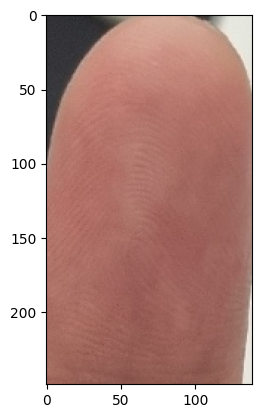

In [17]:
sample_img = np.array(Image.open('./train/images/KakaoTalk_20230802_011016785.jpg'))[min_y:max_y, min_x:max_x, :]
plt.imshow(sample_img)

In [20]:
segmentations = np.array(segmentations, dtype=np.int32)
sample_img = np.array(Image.open('./train/images/KakaoTalk_20230802_011016785.jpg'))[min_y-10:max_y+20, min_x-20:max_x+20, :]
width, height, _ = sample_img.shape
mask = np.zeros(np.array(Image.open('./train/images/KakaoTalk_20230802_011016785.jpg')).shape[:2], dtype=np.uint8)
mask = cv2.fillPoly(mask, [segmentations], 1)[min_y-10:max_y+20, min_x-20:max_x+20]

sample = test_transform(Image.fromarray(sample_img)).reshape(1, 3, 128, 128)
mask_resized = cv2.resize(mask, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
sample_img_resized = (sample[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)

## Get Fingerprints

In [21]:
def enhance_fingerprint(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
    ret, img = cv2.threshold(img, 90, 140, cv2.THRESH_BINARY)
    return img

In [22]:
from torch.nn import init
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# UNet3plus model

In [23]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding

        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size), nn.ReLU(inplace=True),)
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size
        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p), nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')


    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)
        return x

class UNet3Plus(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, bilinear=True, feature_scale=4,
                 is_deconv=True, is_batchnorm=True):
        super(UNet3Plus, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.feature_scale = feature_scale
        self.is_deconv = is_deconv
        self.is_batchnorm = is_batchnorm
        filters = [64, 128, 256, 512, 1024]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.n_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # output
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')


    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d1 = self.outconv1(hd1)  # d1->320*320*n_classes
        return F.sigmoid(d1)

Define loss

In [24]:
def identity_loss(y_true, y_pred):
    loss = torch.mean(torch.abs(y_true - y_pred))
    return loss

## Train

In [26]:
import torch

epochs = 100

input_size = (3, 128, 128)  # Assuming input channels, height, and width

unet = UNet3Plus()
optimizer = torch.optim.Adam(unet.parameters(), lr=3e-4)

for epoch in range(epochs):
  print(f"epoch : {epoch+1}")
  for data in tqdm(train_dataloader, total=len(train_dataloader)):
    images, _ = data
    images = images
    reconstructed = unet(images)

    loss = identity_loss(reconstructed, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("train loss : ", loss.item())

epoch : 1


100%|██████████| 10/10 [02:55<00:00, 17.54s/it]


train loss :  0.10776248574256897
epoch : 2


100%|██████████| 10/10 [02:55<00:00, 17.53s/it]


train loss :  0.05664626136422157
epoch : 3


100%|██████████| 10/10 [02:54<00:00, 17.43s/it]


train loss :  0.047473594546318054
epoch : 4


100%|██████████| 10/10 [04:27<00:00, 26.79s/it]


train loss :  0.02512061782181263
epoch : 5


100%|██████████| 10/10 [02:54<00:00, 17.42s/it]


train loss :  0.021744880825281143
epoch : 6


100%|██████████| 10/10 [17:52<00:00, 107.27s/it]


train loss :  0.03176069259643555
epoch : 7


100%|██████████| 10/10 [18:30<00:00, 111.07s/it]


train loss :  0.026387562975287437
epoch : 8


100%|██████████| 10/10 [22:04<00:00, 132.48s/it] 


train loss :  0.03399407118558884
epoch : 9


100%|██████████| 10/10 [1:13:24<00:00, 440.48s/it]  


train loss :  0.04539569467306137
epoch : 10


100%|██████████| 10/10 [02:55<00:00, 17.54s/it]


train loss :  0.0588335245847702
epoch : 11


100%|██████████| 10/10 [02:54<00:00, 17.49s/it]


train loss :  0.034722331911325455
epoch : 12


100%|██████████| 10/10 [02:54<00:00, 17.46s/it]


train loss :  0.016926951706409454
epoch : 13


100%|██████████| 10/10 [05:21<00:00, 32.17s/it]


train loss :  0.029878143221139908
epoch : 14


100%|██████████| 10/10 [02:53<00:00, 17.40s/it]


train loss :  0.031042098999023438
epoch : 15


100%|██████████| 10/10 [02:54<00:00, 17.49s/it]


train loss :  0.033496953547000885
epoch : 16


100%|██████████| 10/10 [02:55<00:00, 17.60s/it]


train loss :  0.025071417912840843
epoch : 17


100%|██████████| 10/10 [14:28<00:00, 86.83s/it]


train loss :  0.02805737592279911
epoch : 18


100%|██████████| 10/10 [02:54<00:00, 17.41s/it]


train loss :  0.06566855311393738
epoch : 19


100%|██████████| 10/10 [02:54<00:00, 17.45s/it]


train loss :  0.025568075478076935
epoch : 20


100%|██████████| 10/10 [02:54<00:00, 17.43s/it]


train loss :  0.0445326566696167
epoch : 21


100%|██████████| 10/10 [02:55<00:00, 17.56s/it]


train loss :  0.0698716938495636
epoch : 22


100%|██████████| 10/10 [02:56<00:00, 17.63s/it]


train loss :  0.056557945907115936
epoch : 23


100%|██████████| 10/10 [34:52<00:00, 209.28s/it] 


train loss :  0.030210623517632484
epoch : 24


 60%|██████    | 6/10 [13:28<08:59, 134.76s/it]


KeyboardInterrupt: 

# Load trained model

In [28]:
unet3p = torch.load('model/unet3p.pth')

## summary

In [32]:
from torchsummary import summary

summary(unet3p, (3, 128, 128), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 128, 128]           1,792
       BatchNorm2d-2          [1, 64, 128, 128]             128
              ReLU-3          [1, 64, 128, 128]               0
            Conv2d-4          [1, 64, 128, 128]          36,928
       BatchNorm2d-5          [1, 64, 128, 128]             128
              ReLU-6          [1, 64, 128, 128]               0
         unetConv2-7          [1, 64, 128, 128]               0
         MaxPool2d-8            [1, 64, 64, 64]               0
            Conv2d-9           [1, 128, 64, 64]          73,856
      BatchNorm2d-10           [1, 128, 64, 64]             256
             ReLU-11           [1, 128, 64, 64]               0
           Conv2d-12           [1, 128, 64, 64]         147,584
      BatchNorm2d-13           [1, 128, 64, 64]             256
             ReLU-14           [1, 128,

## Unet3plus

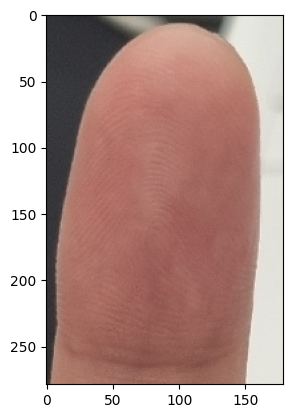

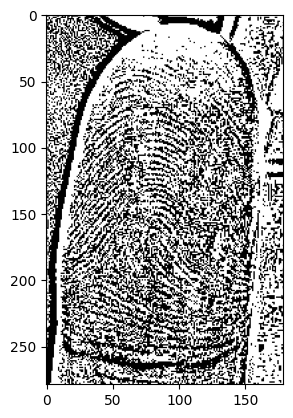

In [33]:
plt.imshow(sample_img)
plt.show()
plt.imshow(enhance_fingerprint(sample_img), cmap='gray')
plt.show()

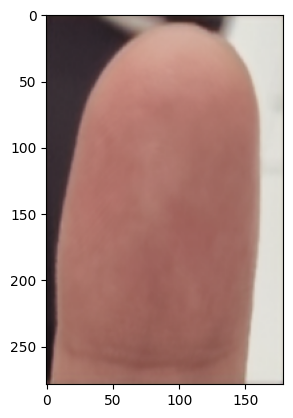

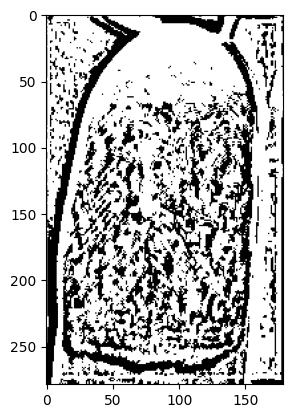

In [34]:
unet3p.eval()
unet_output = cv2.resize((unet3p(sample)[0].permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8), dsize=(height, width), interpolation=cv2.INTER_CUBIC)
plt.imshow(unet_output)
plt.show()
plt.imshow(enhance_fingerprint(unet_output), cmap='gray')
plt.show()

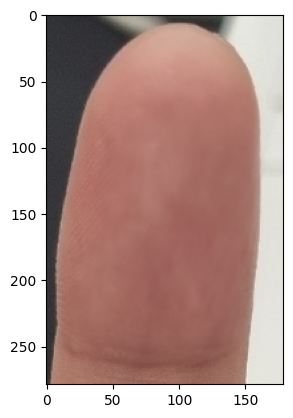

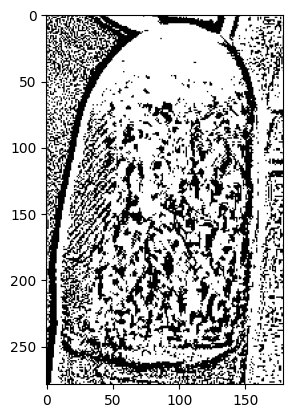

In [35]:
blurry_mask = cv2.blur(mask.astype(np.float32), (20, 20))

masked_img1 = blurry_mask * unet_output[:, :, 0]
masked_img2 = blurry_mask * unet_output[:, :, 1]
masked_img3 = blurry_mask * unet_output[:, :, 2]
output = cv2.merge((masked_img1, masked_img2, masked_img3))

mask_inv = 1 - blurry_mask
masked_img1 = mask_inv * sample_img[:, :, 0]
masked_img2 = mask_inv * sample_img[:, :, 1]
masked_img3 = mask_inv * sample_img[:, :, 2]
masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))

output = np.add(masked_img.astype(np.uint8), output.astype(np.uint8)).astype(np.uint8)

plt.imshow(output)
plt.show()
plt.imshow(enhance_fingerprint(output), cmap='gray')
plt.show()

## Unet

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, skip=True, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        self.skip = skip

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.drop4 = nn.Dropout2d(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv9 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.drop5 = nn.Dropout2d(0.5)

        # Decoder
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv18 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv19 = nn.Conv2d(64, 16, kernel_size=3, padding=1)

        self.conv20 = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = F.relu(self.conv1(x))
        conv1 = F.relu(self.conv2(conv1))
        pool1 = self.pool1(conv1)

        conv2 = F.relu(self.conv3(pool1))
        conv2 = F.relu(self.conv4(conv2))
        pool2 = self.pool2(conv2)

        conv3 = F.relu(self.conv5(pool2))
        conv3 = F.relu(self.conv6(conv3))
        pool3 = self.pool3(conv3)

        conv4 = F.relu(self.conv7(pool3))
        conv4 = F.relu(self.conv8(conv4))
        drop4 = self.drop4(conv4)
        pool4 = self.pool4(drop4)

        # Bottleneck
        conv5 = F.relu(self.conv9(pool4))
        conv5 = F.relu(self.conv10(conv5))
        drop5 = self.drop5(conv5)

        # Decoder
        up6 = self.up6(drop5)
        merge6 = torch.cat([drop4, up6], dim=1)
        conv6 = F.relu(self.conv11(merge6))
        conv6 = F.relu(self.conv12(conv6))

        up7 = self.up7(conv6)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = F.relu(self.conv13(merge7))
        conv7 = F.relu(self.conv14(conv7))

        up8 = self.up8(conv7)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = F.relu(self.conv15(merge8))
        conv8 = F.relu(self.conv16(conv8))

        up9 = self.up9(conv8)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = F.relu(self.conv17(merge9))
        conv9 = F.relu(self.conv18(conv9))
        conv9 = F.relu(self.conv19(conv9))

        conv10 = torch.sigmoid(self.conv20(conv9))

        return conv10

In [37]:
from torchsummary import summary
unet = torch.load('/content/unet.pth')
summary(unet.to('cuda'), (3, 128, 128), batch_size=1)

FileNotFoundError: [Errno 2] No such file or directory: '/content/unet.pth'

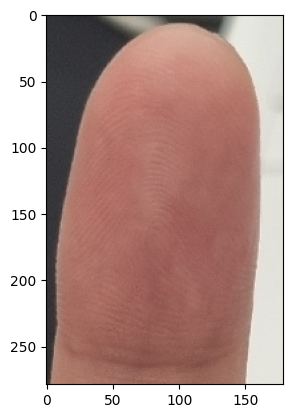

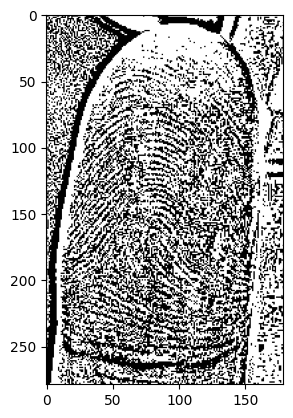

In [38]:
plt.imshow(sample_img)
plt.show()
plt.imshow(enhance_fingerprint(sample_img), cmap='gray')
plt.show()

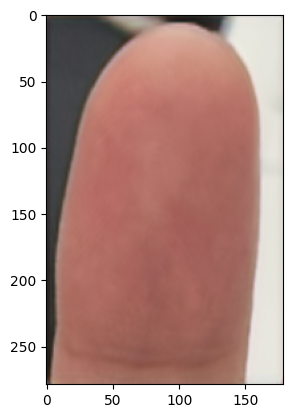

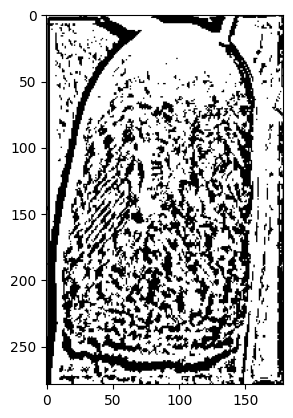

In [39]:
unet.eval()
unet_output = cv2.resize((unet(sample)[0].permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8), dsize=(height, width), interpolation=cv2.INTER_CUBIC)
plt.imshow(unet_output)
plt.show()
plt.imshow(enhance_fingerprint(unet_output), cmap='gray')
plt.show()

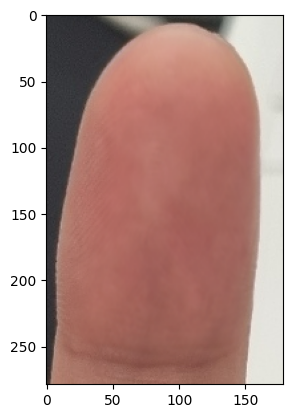

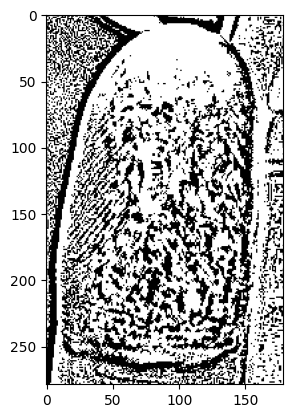

In [40]:
blurry_mask = cv2.blur(mask.astype(np.float32), (20, 20))

masked_img1 = blurry_mask * unet_output[:, :, 0]
masked_img2 = blurry_mask * unet_output[:, :, 1]
masked_img3 = blurry_mask * unet_output[:, :, 2]
output = cv2.merge((masked_img1, masked_img2, masked_img3))

mask_inv = 1 - blurry_mask
masked_img1 = mask_inv * sample_img[:, :, 0]
masked_img2 = mask_inv * sample_img[:, :, 1]
masked_img3 = mask_inv * sample_img[:, :, 2]
masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))

output = np.add(masked_img.astype(np.uint8), output.astype(np.uint8)).astype(np.uint8)

plt.imshow(output)
plt.show()
plt.imshow(enhance_fingerprint(output), cmap='gray')
plt.show()

## Test_lightmodel_1

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, skip=True, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        self.skip = skip

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.drop4 = nn.Dropout2d(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv9 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.drop5 = nn.Dropout2d(0.5)

        # Decoder
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv19 = nn.Conv2d(64, 16, kernel_size=3, padding=1)

        self.conv20 = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = F.relu(self.conv1(x))
        pool1 = self.pool1(conv1)

        conv2 = F.relu(self.conv3(pool1))
        pool2 = self.pool2(conv2)

        conv3 = F.relu(self.conv5(pool2))
        pool3 = self.pool3(conv3)

        conv4 = F.relu(self.conv7(pool3))
        drop4 = self.drop4(conv4)
        pool4 = self.pool4(drop4)

        # Bottleneck
        conv5 = F.relu(self.conv9(pool4))
        drop5 = self.drop5(conv5)

        # Decoder
        up6 = self.up6(drop5)
        merge6 = torch.cat([drop4, up6], dim=1)
        conv6 = F.relu(self.conv11(merge6))

        up7 = self.up7(conv6)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = F.relu(self.conv13(merge7))

        up8 = self.up8(conv7)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = F.relu(self.conv15(merge8))

        up9 = self.up9(conv8)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = F.relu(self.conv17(merge9))
        conv9 = F.relu(self.conv19(conv9))

        conv10 = torch.sigmoid(self.conv20(conv9))

        return conv10

In [42]:
from torchsummary import summary
unet_light_less = torch.load('/content/unet_light_less.pth')
summary(unet_light_less.to('cuda'), (3, 128, 128), batch_size=1)

FileNotFoundError: [Errno 2] No such file or directory: '/content/unet_light_less.pth'

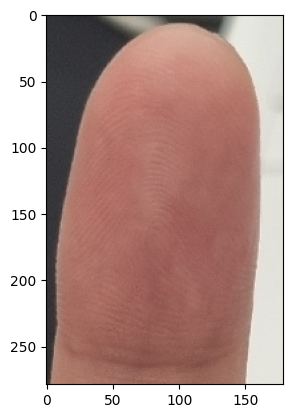

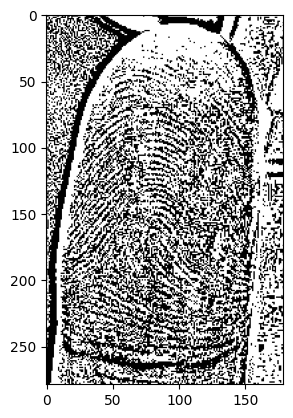

In [43]:
plt.imshow(sample_img)
plt.show()
plt.imshow(enhance_fingerprint(sample_img), cmap='gray')
plt.show()

In [44]:
unet_light_less.eval()
unet_output = cv2.resize((unet_light_less(sample)[0].permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8), dsize=(height, width), interpolation=cv2.INTER_CUBIC)
plt.imshow(unet_output)
plt.show()
plt.imshow(enhance_fingerprint(unet_output), cmap='gray')
plt.show()

NameError: name 'unet_light_less' is not defined

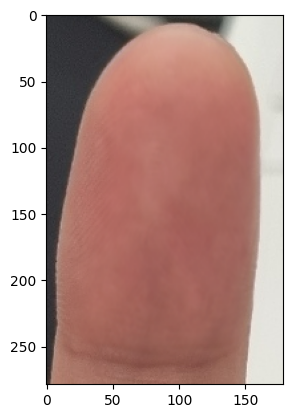

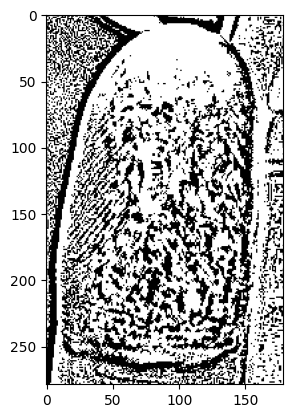

In [45]:
blurry_mask = cv2.blur(mask.astype(np.float32), (20, 20))

masked_img1 = blurry_mask * unet_output[:, :, 0]
masked_img2 = blurry_mask * unet_output[:, :, 1]
masked_img3 = blurry_mask * unet_output[:, :, 2]
output = cv2.merge((masked_img1, masked_img2, masked_img3))

mask_inv = 1 - blurry_mask
masked_img1 = mask_inv * sample_img[:, :, 0]
masked_img2 = mask_inv * sample_img[:, :, 1]
masked_img3 = mask_inv * sample_img[:, :, 2]
masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))

output = np.add(masked_img.astype(np.uint8), output.astype(np.uint8)).astype(np.uint8)

plt.imshow(output)
plt.show()
plt.imshow(enhance_fingerprint(output), cmap='gray')
plt.show()

## Test_lightmodel_2

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, skip=True, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        self.skip = skip

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.drop4 = nn.Dropout2d(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv9 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.drop5 = nn.Dropout2d(0.5)

        # Decoder
        self.up6 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.up7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.up8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.up9 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv19 = nn.Conv2d(32, 16, kernel_size=3, padding=1)

        self.conv20 = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = F.relu(self.conv1(x))
        pool1 = self.pool1(conv1)

        conv2 = F.relu(self.conv3(pool1))
        pool2 = self.pool2(conv2)

        conv3 = F.relu(self.conv5(pool2))
        pool3 = self.pool3(conv3)

        conv4 = F.relu(self.conv7(pool3))
        drop4 = self.drop4(conv4)
        pool4 = self.pool4(drop4)

        # Bottleneck
        conv5 = F.relu(self.conv9(pool4))
        drop5 = self.drop5(conv5)

        # Decoder
        up6 = self.up6(drop5)
        merge6 = torch.cat([drop4, up6], dim=1)
        conv6 = F.relu(self.conv11(merge6))

        up7 = self.up7(conv6)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = F.relu(self.conv13(merge7))

        up8 = self.up8(conv7)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = F.relu(self.conv15(merge8))

        up9 = self.up9(conv8)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = F.relu(self.conv17(merge9))
        conv9 = F.relu(self.conv19(conv9))

        conv10 = torch.sigmoid(self.conv20(conv9))

        return conv10

In [47]:
from torchsummary import summary
unet_light = torch.load('/content/unet_light.pth')
summary(unet_light.to('cuda'), (3, 128, 128), batch_size=1)

FileNotFoundError: [Errno 2] No such file or directory: '/content/unet_light.pth'

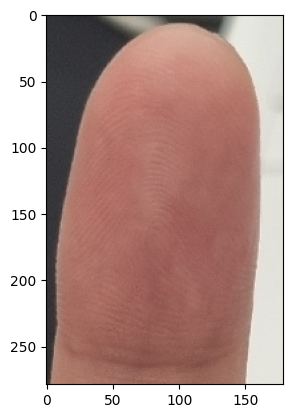

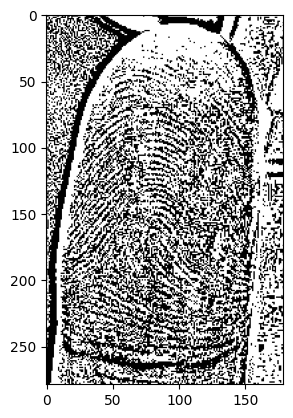

In [48]:
plt.imshow(sample_img)
plt.show()
plt.imshow(enhance_fingerprint(sample_img), cmap='gray')
plt.show()

In [49]:
unet_light.eval()
unet_output = cv2.resize((unet_light(sample)[0].permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8), dsize=(height, width), interpolation=cv2.INTER_CUBIC)
plt.imshow(unet_output)
plt.show()
plt.imshow(enhance_fingerprint(unet_output), cmap='gray')
plt.show()

NameError: name 'unet_light' is not defined

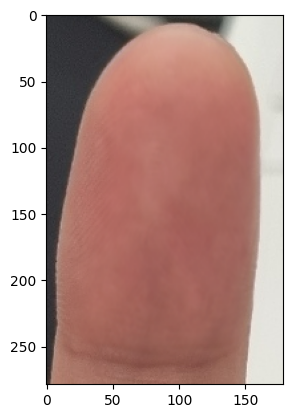

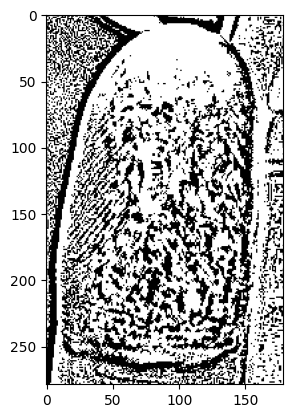

In [50]:
blurry_mask = cv2.blur(mask.astype(np.float32), (20, 20))

masked_img1 = blurry_mask * unet_output[:, :, 0]
masked_img2 = blurry_mask * unet_output[:, :, 1]
masked_img3 = blurry_mask * unet_output[:, :, 2]
output = cv2.merge((masked_img1, masked_img2, masked_img3))

mask_inv = 1 - blurry_mask
masked_img1 = mask_inv * sample_img[:, :, 0]
masked_img2 = mask_inv * sample_img[:, :, 1]
masked_img3 = mask_inv * sample_img[:, :, 2]
masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))

output = np.add(masked_img.astype(np.uint8), output.astype(np.uint8)).astype(np.uint8)

plt.imshow(output)
plt.show()
plt.imshow(enhance_fingerprint(output), cmap='gray')
plt.show()

## Test_lightmodel_3 (Super Light)

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, skip=True, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        self.skip = skip

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.drop3 = nn.Dropout2d(0.5)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.drop4 = nn.Dropout2d(0.5)

        # Decoder
        self.up5 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.up6 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.up7 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(32, 16, kernel_size=3, padding=1)

        self.conv9 = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = F.relu(self.conv1(x))
        pool1 = self.pool1(conv1)

        conv2 = F.relu(self.conv2(pool1))
        pool2 = self.pool2(conv2)

        conv3 = F.relu(self.conv3(pool2))
        drop3 = self.drop3(conv3)
        pool3 = self.pool3(drop3)

        # Bottleneck
        conv4 = F.relu(self.conv4(pool3))
        drop4 = self.drop4(conv4)

        # Decoder
        up5 = self.up5(drop4)
        merge5 = torch.cat([drop3, up5], dim=1)
        conv5 = F.relu(self.conv5(merge5))

        up6 = self.up6(conv5)
        merge6 = torch.cat([conv2, up6], dim=1)
        conv6 = F.relu(self.conv6(merge6))

        up7 = self.up7(conv6)
        merge7 = torch.cat([conv1, up7], dim=1)
        conv7 = F.relu(self.conv7(merge7))
        conv8 = F.relu(self.conv8(conv7))
        conv9 = torch.sigmoid(self.conv9(conv8))

        return conv9

In [52]:
from torchsummary import summary
unet_super_light = torch.load('/content/unet_super_light.pth')
summary(unet_super_light.to('cuda'), (3, 128, 128), batch_size=1)

FileNotFoundError: [Errno 2] No such file or directory: '/content/unet_super_light.pth'

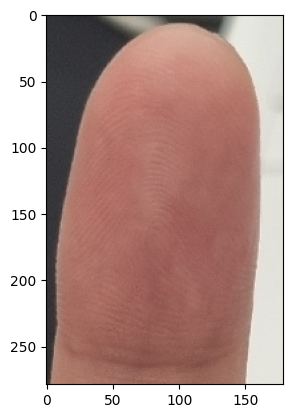

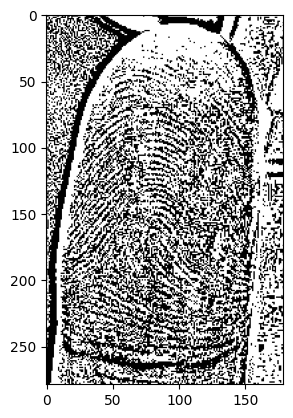

In [53]:
plt.imshow(sample_img)
plt.show()
plt.imshow(enhance_fingerprint(sample_img), cmap='gray')
plt.show()

In [54]:
unet_super_light.eval()
unet_output = cv2.resize((unet_super_light(sample)[0].permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8), dsize=(height, width), interpolation=cv2.INTER_CUBIC)
plt.imshow(unet_output)
plt.show()
plt.imshow(enhance_fingerprint(unet_output), cmap='gray')
plt.show()

NameError: name 'unet_super_light' is not defined

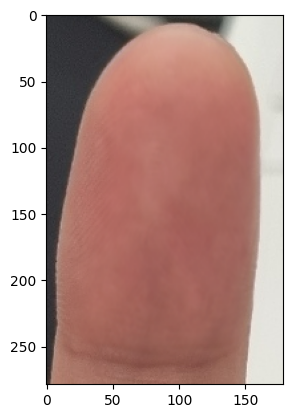

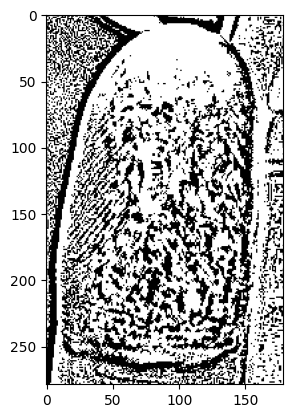

In [55]:
blurry_mask = cv2.blur(mask.astype(np.float32), (20, 20))

masked_img1 = blurry_mask * unet_output[:, :, 0]
masked_img2 = blurry_mask * unet_output[:, :, 1]
masked_img3 = blurry_mask * unet_output[:, :, 2]
output = cv2.merge((masked_img1, masked_img2, masked_img3))

mask_inv = 1 - blurry_mask
masked_img1 = mask_inv * sample_img[:, :, 0]
masked_img2 = mask_inv * sample_img[:, :, 1]
masked_img3 = mask_inv * sample_img[:, :, 2]
masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))

output = np.add(masked_img.astype(np.uint8), output.astype(np.uint8)).astype(np.uint8)

plt.imshow(output)
plt.show()
plt.imshow(enhance_fingerprint(output), cmap='gray')
plt.show()

In [56]:
import torch

epochs = 100

input_size = (3, 128, 128)  # Assuming input channels, height, and width

unet = UNet().to('cuda')
optimizer = torch.optim.Adam(unet.parameters(), lr=3e-4)

for epoch in range(epochs):
  print(f"epoch : {epoch+1}")
  for data in tqdm(train_dataloader, total=len(train_dataloader)):
    images, _ = data
    images = images.to('cuda')
    reconstructed = unet(images)

    loss = identity_loss(reconstructed, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("train loss : ", loss.item())

AssertionError: Torch not compiled with CUDA enabled